<table width="50%"><tr>
<td> <img src="figs/dipy_logo.png" align="left" alt="Drawing" style="width: 155px;"/> </td>
<td> <img src="figs/gsoc_logo.png" align="right" alt="Drawing" style="width: 220px;"/> </td>
</tr></table>

**Student**\
David Romero-Bascones\
**Mentors**\
Bramsh Qamar Chandio\
Shreyas Fadnavis\
Jong Sung Park

## **Streamline Linear Registration: optimization symmetry check**

Test of how symmetric is SLR for different transformations.

### **Import libraries**

In [76]:
from datetime import datetime
from itertools import combinations
from multiprocessing import Pool, cpu_count
import os

from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

#import matplotlib.pyplot as plt
from dipy.io.streamline import load_trk
from dipy.segment.clustering import qbx_and_merge
from dipy.align.streamlinear import StreamlineLinearRegistration, compose_matrix44, remove_clusters_by_size
from dipy.tracking.streamline import set_number_of_points, transform_streamlines, orient_by_streamline, select_random_set_of_streamlines, Streamlines

In [79]:
def run_experiment(centroids, all_pairs, N, model, n_param, seed, verbose):
    
    np.random.seed(seed)    
    index = np.random.permutation(len(centroids))
    
    X = np.empty((N, 2, n_param))

    for i in range(N):
        ind1 = all_pairs[index[i]][0]
        ind2 = all_pairs[index[i]][1]
    
        centroids1 = centroids[ind1]
        centroids2 = centroids[ind2]
        
        srr1 = StreamlineLinearRegistration(x0=model, method='Powell')
        srm1 = srr1.optimize(static=centroids1, moving=centroids2)

        srr2 = StreamlineLinearRegistration(x0=model, method='Powell')
        srm2 = srr2.optimize(static=centroids2, moving=centroids1)
        
        X[i, 0, :] = srm1.xopt
        X[i, 1, :] = srm2.xopt

        if verbose:
            clear_output(wait=True)
            print(f'{i+1}/{N}')
    return x

### **Load bundles**

In [7]:
# Data configurattion
in_dir = '/home/david/Dropbox (MGEP)/projects/GSoC-2021/data/PPMI_data'

bundle_name = 'AF_L'
subjects = pd.read_csv(f'{in_dir}/subjects.csv', delimiter='\t',
                       dtype='object')['participant']

# Bundle preprocessing
global bundles, centroids
bundles = []
centroids = []

n_stream = 2500
n_point = 20
qbx_th = 5

for sub in subjects:
    file = f'{in_dir}/{sub}/org_bundles/streamlines_moved_{bundle_name}__labels__recognized_orig.trk'
    bundle_obj = load_trk(file, reference='same', bbox_valid_check=False)

    # Preprocessing
    bundle = set_number_of_points(bundle_obj.streamlines, n_point)
    bundle = select_random_set_of_streamlines(bundle, n_stream)
    bundles.append(bundle)
    
    # Centroids
    cluster = qbx_and_merge(bundle, thresholds=[qbx_th])
    centroids.append(remove_clusters_by_size(cluster, 1))

# Get all bundle pair combinations
all_pairs = list(combinations(np.arange(len(subjects)),2))

seed = 666

### **Translation**

#### Run simulations

In [80]:
model = 'Translation'
n_param = 3
N = 5

X = run_experiment(centroids, all_pairs, N, model, n_param, seed, verbose=True)

5/5


#### Plot results

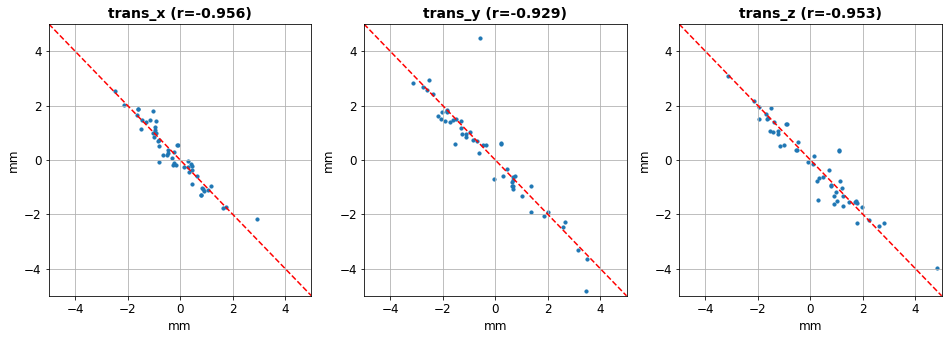

In [46]:
names = ['trans_x', 'trans_y', 'trans_z']
units = ['mm', 'mm', 'mm']
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(16, 5)
for i, ax in enumerate(axs.reshape(-1)):
    x1 = X[:, 0, i]
    x2 = X[:, 1, i]

    r, p = pearsonr(x1, x2)
    r = np.round(r, 3)

    ax.scatter(x1, x2, 10)

    xl = 5
    ax.plot([-xl, xl], [xl, -xl], color='red', linestyle='dashed')
    ax.set_xlim(-xl, xl)
    ax.set_ylim(-xl, xl)

    ax.set_title(f'{names[i]} (r={r})', fontsize=14, fontweight="bold")
    ax.set_xlabel(units[i], fontsize=12)
    ax.set_ylabel(units[i], fontsize=12)
    ax.tick_params(axis='both',which='major',labelsize=12)
    ax.grid()

### **Rigid**

#### Run simulations

In [81]:
model = 'Rigid'
n_param = 6
N = 50

X = run_experiment(centroids, all_pairs, N, model, n_param, seed, verbose=True)

50/50


#### Plot results

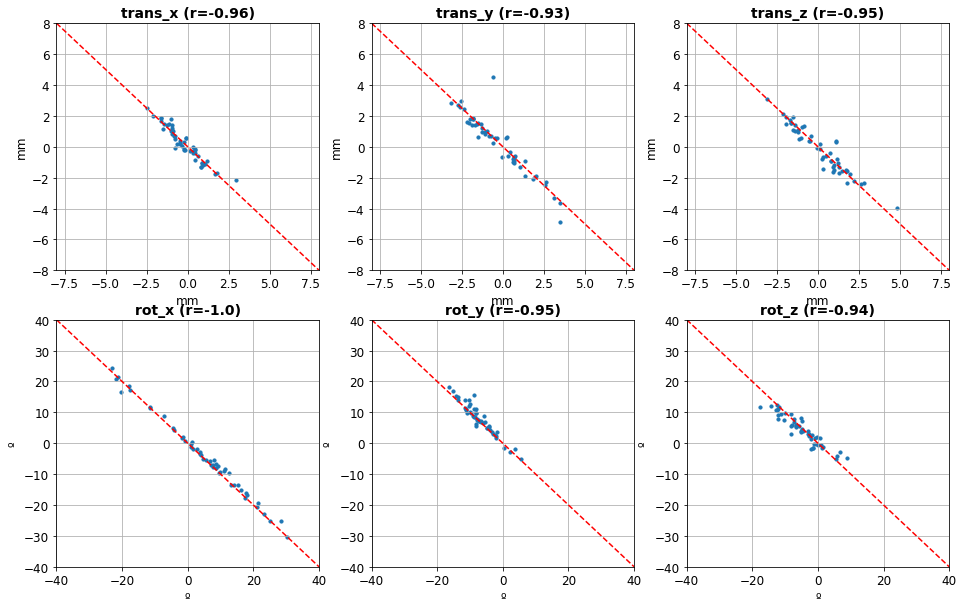

In [48]:
names = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']
units = ['mm', 'mm', 'mm', 'º', 'º', 'º']
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(16, 10)

for i, ax in enumerate(axs.reshape(-1)):
    x1 = x[:, 0, i]
    x2 = x[:, 1, i]

    r, p = pearsonr(x1, x2)
    r = np.round(r, 2)

    ax.scatter(x1, x2, 10)
    if i < 3:
        xl = 8
        ax.plot([-xl, xl], [xl, -xl], color='red', linestyle='dashed')
        ax.set_xlim(-xl, xl)
        ax.set_ylim(-xl, xl)
    elif i < 6:
        xl = 40
        ax.plot([-xl, xl], [xl, -xl], color='red', linestyle='dashed')
        ax.set_xlim(-xl, xl)
        ax.set_ylim(-xl, xl)

    ax.set_title(f'{names[i]} (r={r})', fontsize=14, fontweight="bold")
    ax.set_xlabel(units[i], fontsize=12)
    ax.set_ylabel(units[i], fontsize=12)
    ax.tick_params(axis='both',which='major',labelsize=12)
    ax.grid()

### **Scaling**

#### Run simulations

In [49]:
model = 'Scaling'
n_param = 9
N = 50

X = run_experiment(centroids, all_pairs, N, model, n_param, seed, verbose=True)

#### Plot results

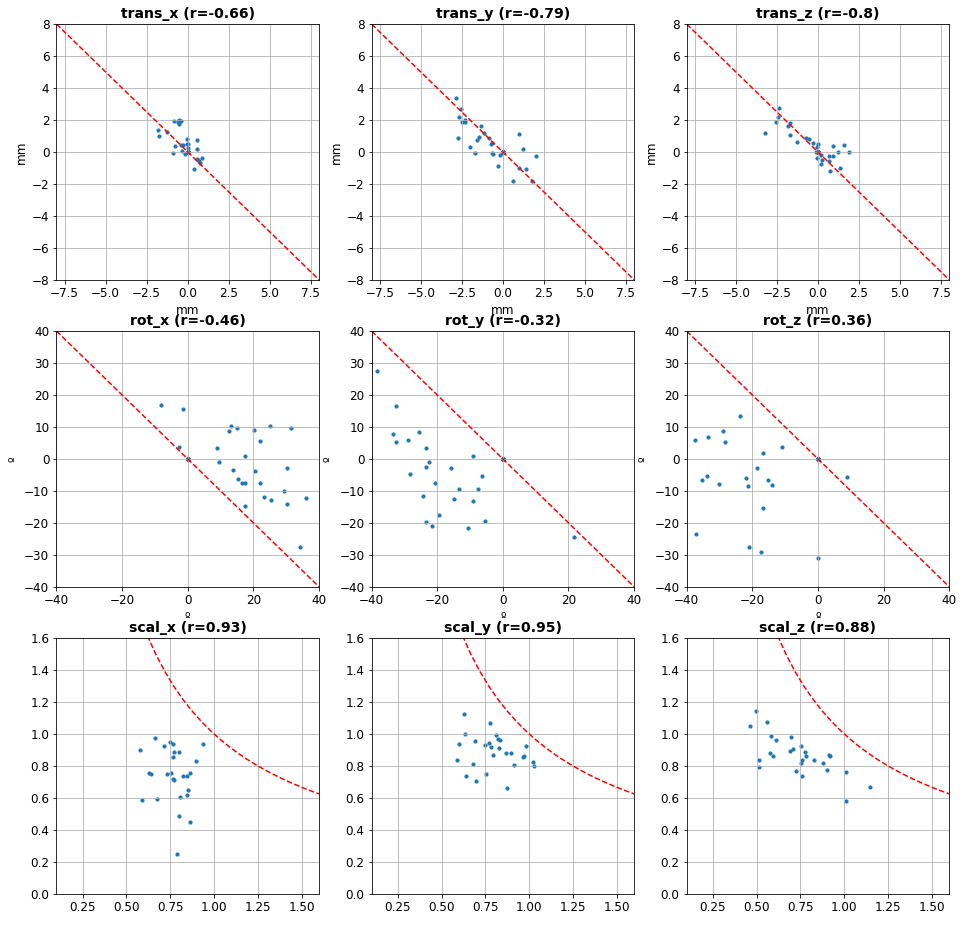

In [52]:
names = ['trans_x', 'trans_y', 'trans_z', 'rot_x',
         'rot_y', 'rot_z', 'scal_x', 'scal_y', 'scal_z']
units = ['mm', 'mm', 'mm', 'º', 'º', 'º', ' ', ' ', ' ']
fig, axs = plt.subplots(3, 3)
fig.set_size_inches(16, 16)
for i, ax in enumerate(axs.reshape(-1)):
    x1 = x[:, 0, i]
    x2 = x[:, 1, i]

    r, p = pearsonr(x1, x2)
    r = np.round(r, 2)

    ax.scatter(x1, x2, 10)
    if i < 3:
        xl = 8
        ax.plot([-xl, xl], [xl, -xl], color='red', linestyle='dashed')
        ax.set_xlim(-xl, xl)
        ax.set_ylim(-xl, xl)
    elif i < 6:
        xl = 40
        ax.plot([-xl, xl], [xl, -xl], color='red', linestyle='dashed')
        ax.set_xlim(-xl, xl)
        ax.set_ylim(-xl, xl)
    elif i < 9:
        xl1 = 0.1
        xl2 = 1.6
        xt = np.linspace(xl1, xl2, 30)
        ax.plot(xt, 1/xt, color='red', linestyle='dashed')
        ax.set_xlim(xl1, xl2)
        ax.set_ylim(0, 1.6)

    ax.set_title(f'{names[i]} (r={r})', fontsize=14, fontweight="bold")
    ax.set_xlabel(units[i], fontsize=12)
    ax.set_ylabel(units[i], fontsize=12)
    ax.grid()
    ax.tick_params(axis='both',which='major',labelsize=12)

### **Affine**

#### Run simulations

In [53]:
model = 'Affine'
n_param = 12
N = 5

X = run_experiment(centroids, all_pairs, N, model, n_param, seed, verbose=True)

#### Plot results

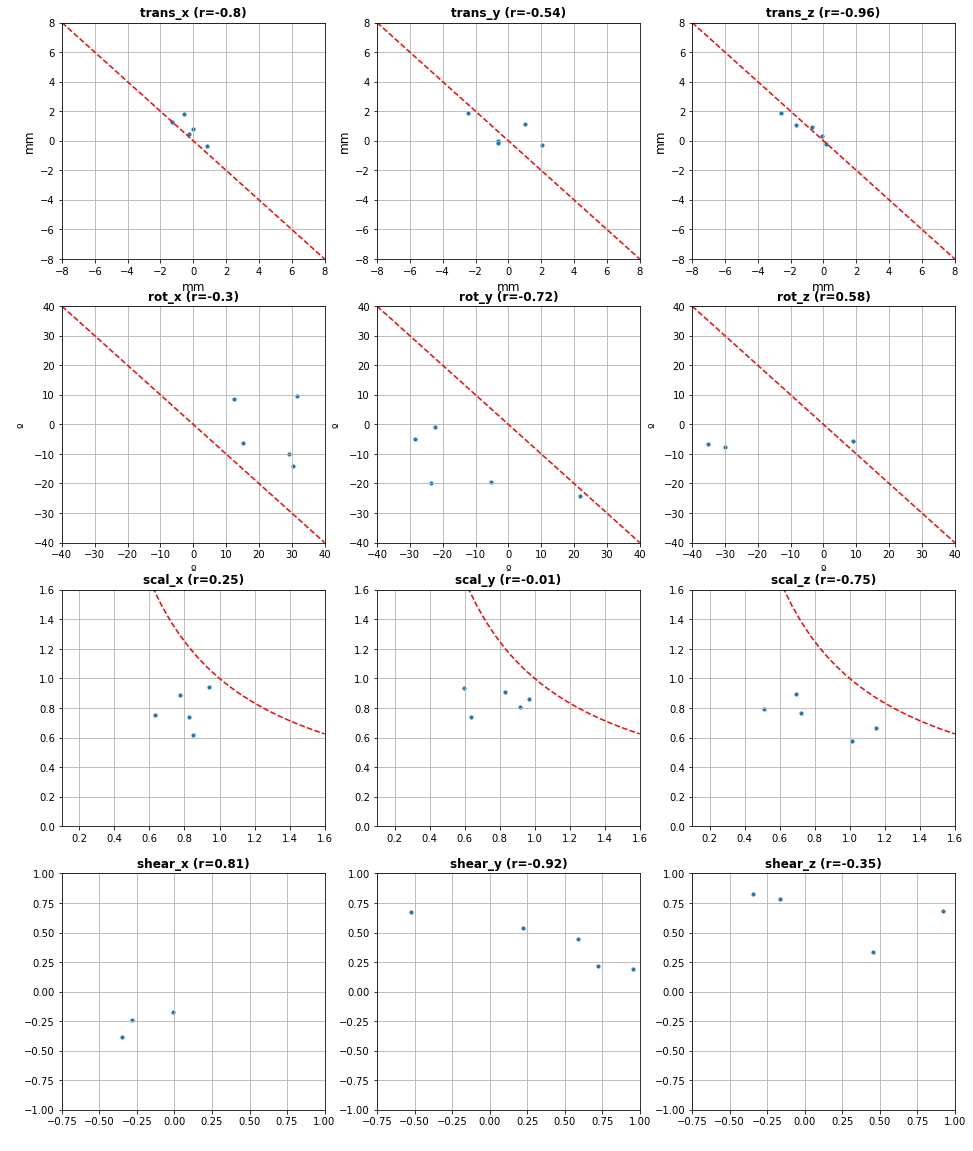

In [56]:
names = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z',
         'scal_x', 'scal_y', 'scal_z', 'shear_x', 'shear_y', 'shear_z']

units = ['mm', 'mm', 'mm', 'º', 'º', 'º', ' ', ' ', ' ', ' ', ' ', ' ']

fig, axs = plt.subplots(4, 3)
fig.set_size_inches(16, 20)

for i, ax in enumerate(axs.reshape(-1)):
    x1 = x[:, 0, i]
    x2 = x[:, 1, i]

    r, p = pearsonr(x1, x2)
    r = np.round(r, 2)

    xmin = np.concatenate((x1, x2)).min()
    xmax = np.concatenate((x1, x2)).max()

    ax.scatter(x1, x2, 10)
    if i < 3:
        xl = 8
        ax.plot([-xl, xl], [xl, -xl], color='red', linestyle='dashed')
        ax.set_xlim(-xl, xl)
        ax.set_ylim(-xl, xl)
    elif i < 6:
        xl = 40
        ax.plot([-xl, xl], [xl, -xl], color='red', linestyle='dashed')
        ax.set_xlim(-xl, xl)
        ax.set_ylim(-xl, xl)
    elif i < 9:
        xl1 = 0.1
        xl2 = 1.6
        xt = np.linspace(xl1, xl2, 30)
        ax.plot(xt, 1/xt, color='red', linestyle='dashed')
        ax.set_xlim(xl1, xl2)
        ax.set_ylim(0, 1.6)
    elif i < 12:
        ax.set_xlim(-0.75, 1)
        ax.set_ylim(-1, 1)

    ax.set_title(f'{names[i]} (r={r})', fontweight="bold")
    ax.set_xlabel(units[i], fontsize=12)
    ax.set_ylabel(units[i], fontsize=12)
    ax.grid()